In [20]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from IPython import display
from matplotlib import pyplot as plt


batch_size = 256

In [21]:
def get_dataloader_workers():
    return 4

In [22]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集,然后将其加载到内存中,如果之前下载过了只要指明路径就不会重复下载,而是直接调用"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    '''这里指明了新的trans也会按照trans定义的转换操作进行处理,不用重新下载一遍数据'''
    mnist_train = torchvision.datasets.FashionMNIST(root=r'..\data\F_MNIST_data_train', train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(root=r'..\data\F_MNIST_data_test', train=False, transform=trans, download=True)

    return (
        data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
        data.DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers())
    )

In [23]:
train_iter,test_iter = load_data_fashion_mnist(batch_size)

In [24]:
num_inputs = 784
num_outputs = 10

w = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

实现softmax

In [25]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1,keepdim=True)
    return X_exp/partition#广播机制

实现softmax回归

In [26]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1,w.shape[0])),w)+b)

实现交叉熵损失函数

In [27]:
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])

将预测类别和真实y元素进行比较

In [28]:
def accuracy(y_hat,y):
    '''计算正确预测的数量'''
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [29]:
class Accumulator(object):
    def __init__(self, n):
        """
        初始化累加器。
        :param n: 要累加的统计量的数量
        """
        self.data = [0.0] * n

    def add(self, *args):
        """
        累加输入的值。
        :param args: 要累加的值，数量应与初始化时的统计量数量一致
        """
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        """
        获取指定索引位置的累加值。
        :param idx: 索引
        :return: 对应索引位置的累加值
        """
        return self.data[idx]   

In [30]:
def evaluate_accuracy(net,data_iter):
    '''计算指定数据集上模型的精度'''
    if isinstance(net, torch.nn.Module):
        net.eval()#设置模型为评估模式
    metric = Accumulator(2)
    for X,y in data_iter:
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [31]:
evaluate_accuracy(net,test_iter)

0.1333

Softmax回归训练

In [32]:
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X,y in train_iter:
        y_hat = net(X)
        l = loss(y_hat,y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat,y), 
                y.size().numel()
            )
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(
                float(l.sum()), accuracy(y_hat,y), y.numel()
            )
    return metric[0]/metric[2], metric[1]/metric[2]

动画中绘制数据

In [33]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), figsize=(10, 4)):
        
        self.X = self.Y = None
        self.fmts = fmts
        if legend is None:
            legend = []
        
        # 创建两个子图，第一个用于 loss，第二个用于其他数据
        self.fig, self.axes = plt.subplots(1, 2, figsize=figsize, sharex=True)
        
        self.config_axes_loss = lambda: self.set_axes(self.axes[0], xlabel, "Loss", xlim, None, xscale, yscale, [legend[0]])
        self.config_axes_main = lambda: self.set_axes(self.axes[1], xlabel, ylabel, xlim, ylim, xscale, yscale, legend[1:])
    
    def set_axes(self, ax, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
        """手动设置坐标轴"""
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_xscale(xscale)
        ax.set_yscale(yscale)
        if xlim: ax.set_xlim(xlim)
        if ylim: ax.set_ylim(ylim)
        if legend: ax.legend(legend)

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if self.X is None:
            self.X = [[] for _ in range(n)]
        if self.Y is None:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        
        self.axes[0].cla()  
        self.axes[1].cla()  
        
        # 绘制 loss (单独的曲线)
        self.axes[0].plot(self.X[0], self.Y[0], self.fmts[0], label="Loss")
        self.config_axes_loss()
        
        # 绘制其余数据
        for x, y, fmt in zip(self.X[1:], self.Y[1:], self.fmts[1:]):
            self.axes[1].plot(x, y, fmt)
        self.config_axes_main()
        
        display(self.fig)

训练函数

In [34]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs,updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1.0],legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter,loss,updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1,train_metrics + (test_acc,))
    train_loss,train_acc = train_metrics

In [35]:
def sgd(params,lr,batch_size):#params就是（w，b）全部参数的意思，lr是学习率
    with torch.no_grad():
        for param in params:#对每个参数进行梯度反方向的更新
            param -= lr*param.grad / batch_size#对这批量的数据的损失函数求平均放在这个操作放在这里是一样的
            param.grad.zero_()#梯度不会自己删除，要重新置零

In [36]:
lr = 0.1

def updater(batch_size):
    return sgd([w,b], lr, batch_size)

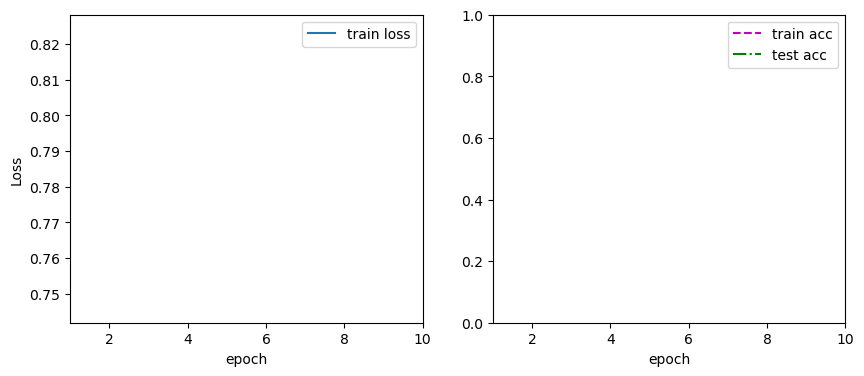

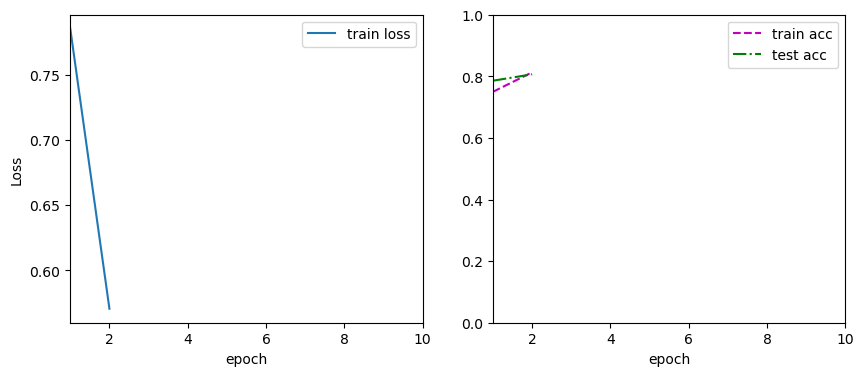

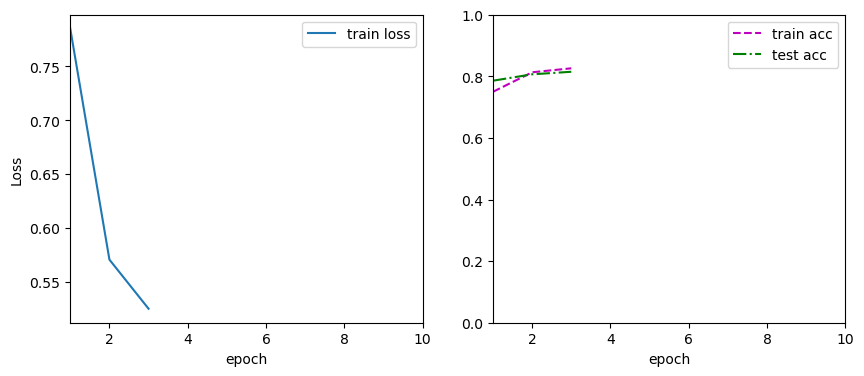

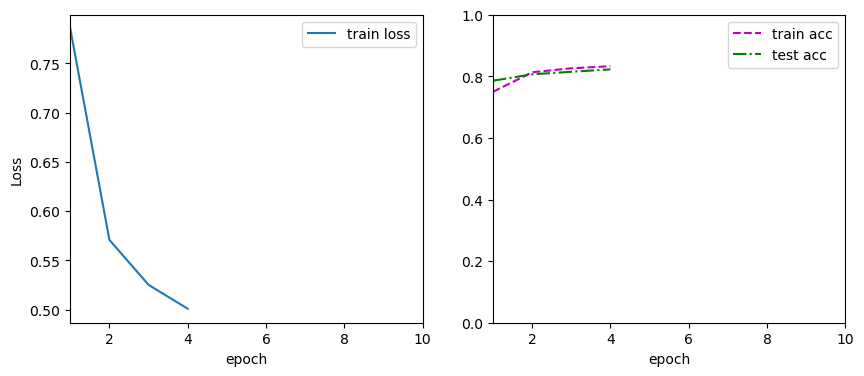

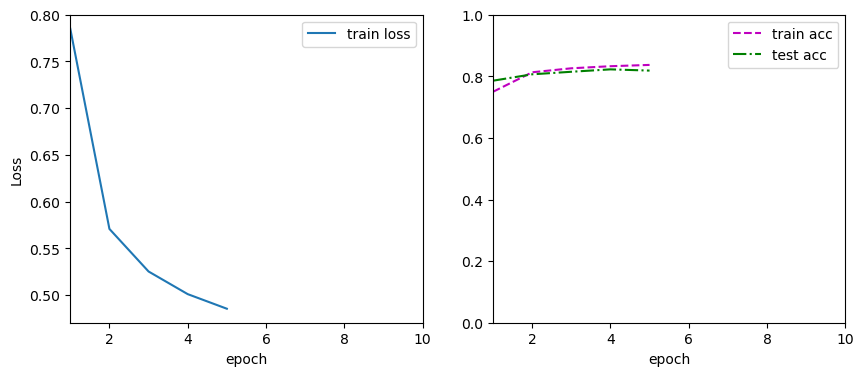

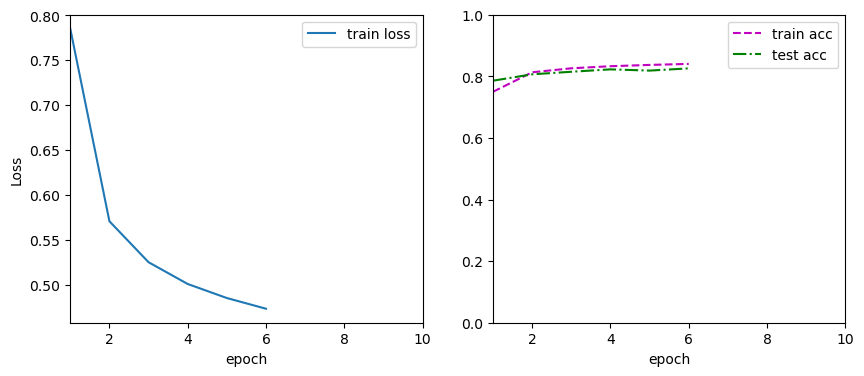

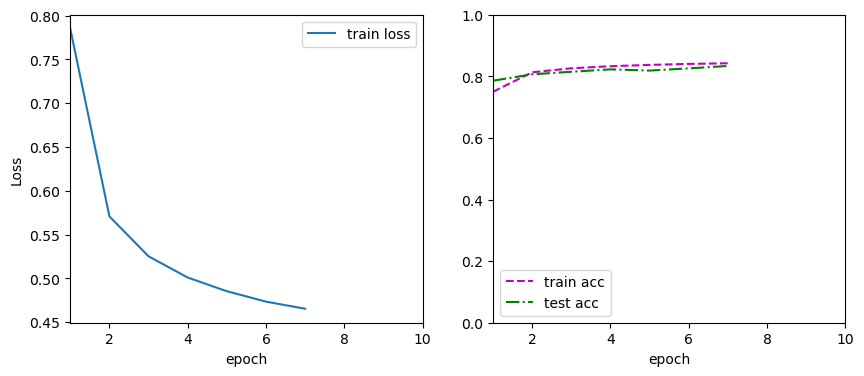

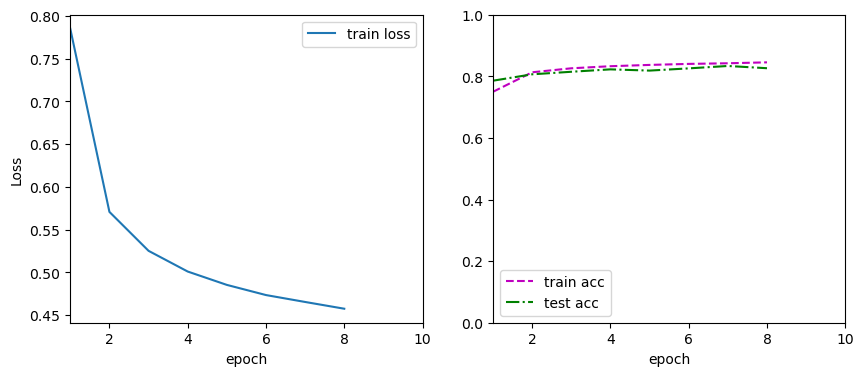

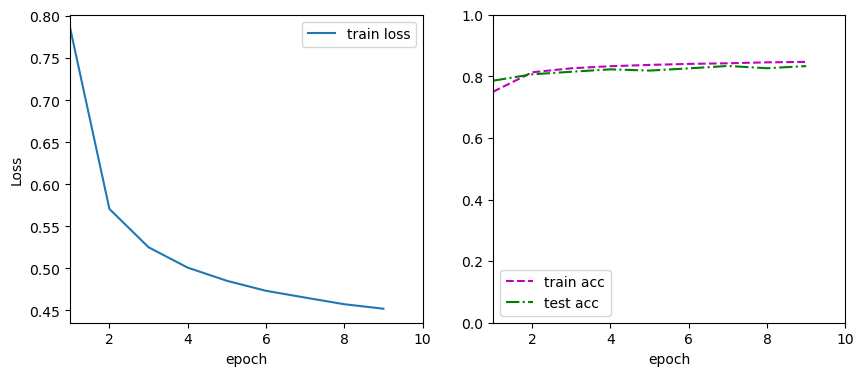

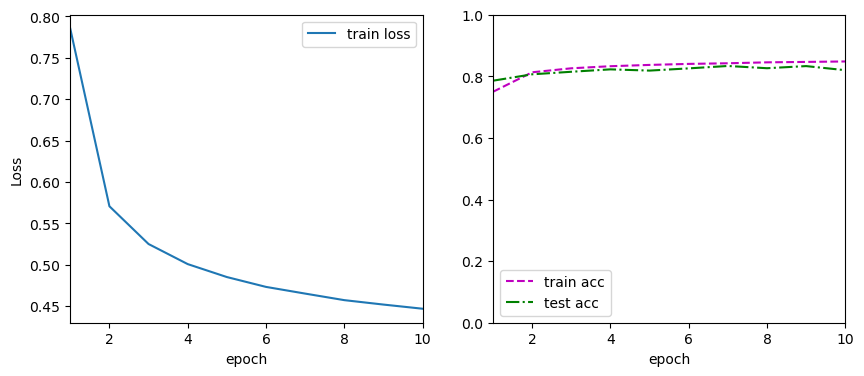

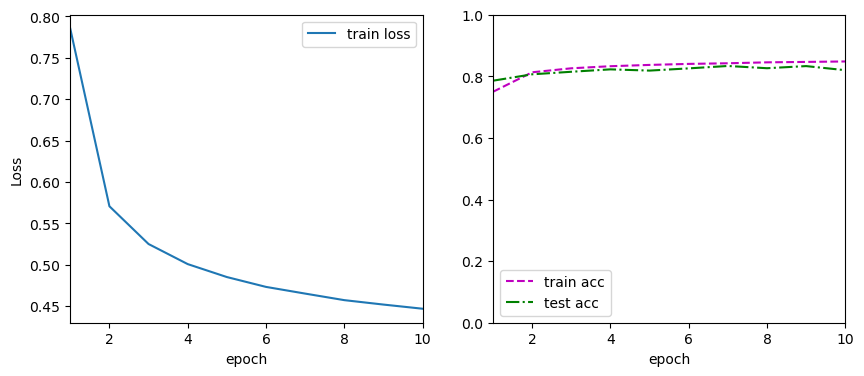

In [37]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)